# import jMF2D

In [1]:
from jMF2D import runDeconvolution, prepare_for_Deconvolution
import pandas as pd
import numpy as np

## read datas

In [2]:
# simulated dataset 1
data_dir = "./datasets/simulated_dataset1/"
sc_data = pd.read_csv(data_dir + "sc.csv", index_col=0)
sp_data = pd.read_csv(data_dir + "sp.csv", index_col=0)
sc_annotation = pd.read_csv(data_dir + "sc_annotation.csv", index_col=0)

## prepare the datas for Deconvolution and pre-process

In [3]:
# prepare_for_Deconvolution
X, Y, L = prepare_for_Deconvolution(sc_data=sc_data,sc_annotation=sc_annotation, sp_data=sp_data,
                          filter=False, construct=False)

## select the high varibale genes...
## preprocess the scRNA-seq anndata...
## Each celltype contains the number of cells: 
                                    VASN  ITGB2  C11orf96  PCP4  JSRP1  \
annotation                                                              
B cells                             640    640       640   640    640   
EPCAM+ cells and cholangiocytes     119    119       119   119    119   
Hepatocytes                        3501   3501      3501  3501   3501   
LSEC                                633    633       633   633    633   
NK,NKT and T cells                 2018   2018      2018  2018   2018   
Stellate cells and myofibroblasts    37     37        37    37     37   

                                   ZBTB20-AS1  KLF7  CHST12  ARNT2  ADGRE5  \
annotation                                                                   
B cells                                   640   640     640    640     640   
EPCAM+ cells and cholangiocytes           119   119     

## Deconvolution

In [4]:
# parameters
alpha = 1
beta = 1
gamma = 1
loss = 1e-4
max_iter = 1000
seed = 0
initial_B = 1
initial_F = 0
sym = 1
normbyspot = 0

In [5]:
# run Deconvolution
F, Z = runDeconvolution(X.values.tolist(), Y.values.tolist(), L.tolist(), alpha, beta, gamma, loss, max_iter,
    seed, initial_B, initial_F, sym, normbyspot)

# Plot the different algorithms to get the performance on each indicator

In [6]:
from sklearn.preprocessing import normalize
from utils import RMSE,ssim,pearsonr,JS
import seaborn as sns
import matplotlib.pyplot as plt
ohter_res_dir = "./datasets/simulated_dataset1/other_res/"
DSTG_column_label = ["LSEC","EPCAM+ cells and cholangiocytes","NK,NKT and T cells","Hepatocytes","B cells","Stellate cells and myofibroblasts"]

ground_sort_columns = pd.read_csv(ohter_res_dir + "/RCTD_res.csv", index_col=0).columns.values
sort_columns = ground_sort_columns

## ground truth spatial
ground_truth = pd.read_csv(ohter_res_dir +"ground_truth.csv", index_col=0)
ground_truth = ground_truth.div(ground_truth.sum(axis=1), axis='rows')
ground_truth = ground_truth[sort_columns]

# jMF2D
F = normalize(F, axis=0, norm='l1')
jMF2D = pd.DataFrame(data=F.T, index=ground_truth.index.values, columns=Y.columns.values)
# SPOTlight
spotlight_res = pd.read_csv(ohter_res_dir +"/SPOTlight_res.csv", index_col=0)
spotlight_res.index = ground_truth.index.values
# RCTD
RCTD_res = pd.read_csv(ohter_res_dir + "/RCTD_res.csv", index_col=0)
RCTD_res.index = ground_truth.index.values
# Cell2lcoation
cell2location_res = pd.read_csv(ohter_res_dir +"/cell2location_res.csv", index_col=0)
cell2location_res = cell2location_res.div(cell2location_res.sum(axis=1), axis='rows') # 按spot归一化
cell2location_res.columns = sort_columns
cell2location_res.index = ground_truth.index.values
# Redeconve
Redeconve_res = pd.read_csv(ohter_res_dir +"/Redeconve_res.csv", index_col=0)
Redeconve_res = Redeconve_res.div(Redeconve_res.sum(axis=1), axis='rows') # 按spot归一化
Redeconve_res.index = ground_truth.index.values
# CARD
CARD_res = pd.read_csv(ohter_res_dir +"/CARD_res.csv", index_col=0)
CARD_res = CARD_res[sort_columns]
CARD_res.index = ground_truth.index.values
# DestVI
DestVI_res = pd.read_csv(ohter_res_dir +"/DestVI_res.csv", index_col=0)
DestVI_res = DestVI_res[sort_columns]
# SpatialDWLS
SpatialDWLS_res = pd.read_csv(ohter_res_dir +"/SpatialDWLS_res.csv", index_col=0).iloc[:,1:]
SpatialDWLS_res = SpatialDWLS_res[sort_columns]
SpatialDWLS_res.index = ground_truth.index.values
# DSTG
DSTG_res = pd.read_csv(ohter_res_dir +"/DSTG_res.csv", header=None)
DSTG_res.columns = DSTG_column_label
DSTG_res = DSTG_res[sort_columns]

Text(0.5, 1.0, 'RMSE')

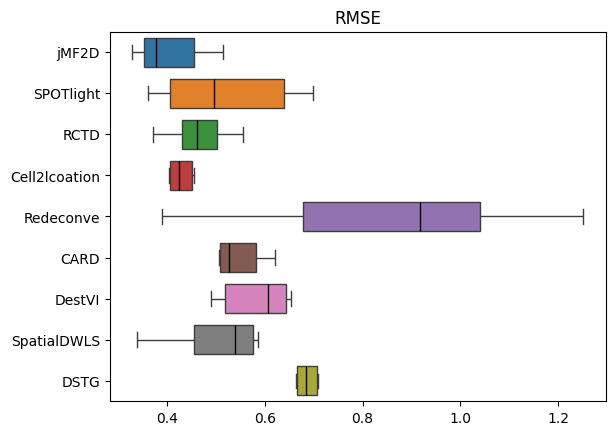

In [7]:
## RMSE
# jMF2D
my_rmse = RMSE(ground_truth, jMF2D)
# SPOTlight
spotlight_rmse = RMSE(ground_truth, spotlight_res)
# RCTD
RCTD_rmse = RMSE(ground_truth, RCTD_res)
# Cell2lcoation
cell2location_rmse= RMSE(ground_truth, cell2location_res)
# Redeconve
Redeconve_rmse = RMSE(ground_truth, Redeconve_res)
# CARD
CARD_rmse = RMSE(ground_truth, CARD_res)
# DestVI
DestVI_rmse = RMSE(ground_truth, DestVI_res)
# SpatialDWLS
SpatialDWLS_rmse = RMSE(ground_truth, SpatialDWLS_res)
# DSTG
DSTG_rmse = RMSE(ground_truth, DSTG_res)

# show
rmse_data = pd.DataFrame({'jMF2D':my_rmse.values[0], 'SPOTlight':spotlight_rmse.values[0],
                         'RCTD':RCTD_rmse.values[0], 'Cell2lcoation':cell2location_rmse.values[0],
                          'Redeconve':Redeconve_rmse.values[0],
                          "CARD":CARD_rmse.values[0],
                          "DestVI":DestVI_rmse.values[0], "SpatialDWLS":SpatialDWLS_rmse.values[0],
                          "DSTG":DSTG_rmse.values[0]})
sns.boxplot(data=rmse_data, orient='h', width=0.7, showfliers=False, medianprops=dict(color="black"))
plt.title("RMSE")

Text(0.5, 1.0, 'PCC')

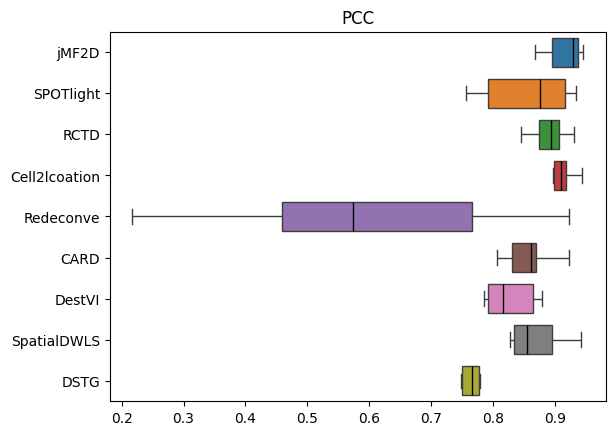

In [8]:
## PCC
# jMF2D
my_pcc = pearsonr(ground_truth, jMF2D)
# SPOTlight
spotlight_pcc = pearsonr(ground_truth, spotlight_res)
# RCTD
RCTD_pcc = pearsonr(ground_truth, RCTD_res)
# Cell2lcoation
cell2location_pcc = pearsonr(ground_truth, cell2location_res)
# Redeconve
Redeconve_pcc  = pearsonr(ground_truth, Redeconve_res)
# CARD
CARD_pcc = pearsonr(ground_truth, CARD_res)
# DestVI
DestVI_pcc = pearsonr(ground_truth, DestVI_res)
# SpatialDWLS
SpatialDWLS_pcc = pearsonr(ground_truth, SpatialDWLS_res)
# DSTG
DSTG_pcc = pearsonr(ground_truth, DSTG_res)

# show
pcc_data = pd.DataFrame({'jMF2D':my_pcc.values[0], 'SPOTlight':spotlight_pcc.values[0],
                         'RCTD':RCTD_pcc.values[0], 'Cell2lcoation':cell2location_pcc.values[0],
                          'Redeconve':Redeconve_pcc.values[0],
                         "CARD":CARD_pcc.values[0],
                          "DestVI":DestVI_pcc.values[0], "SpatialDWLS":SpatialDWLS_pcc.values[0],
                         "DSTG":DSTG_pcc.values[0]})
sns.boxplot(data=pcc_data, orient='h', width=0.7, showfliers=False,medianprops=dict(color="black"))
plt.title("PCC")

Text(0.5, 1.0, 'JS')

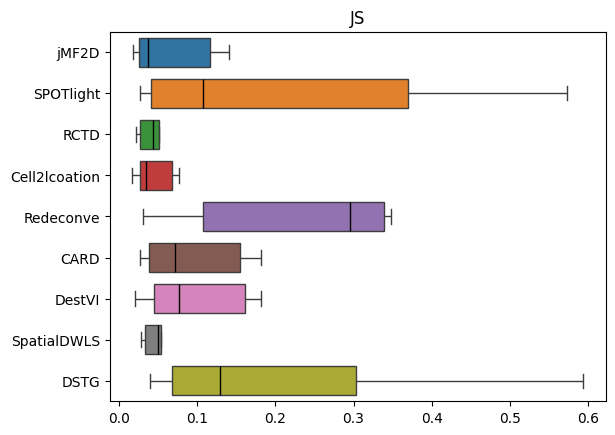

In [9]:
## JS
# jMF2D
my_JS = JS(ground_truth, jMF2D)
# SPOTlight
spotlight_JS = JS(ground_truth, spotlight_res)
# RCTD
RCTD_JS = JS(ground_truth, RCTD_res)
# Cell2lcoation
cell2location_JS = JS(ground_truth, cell2location_res)
# Redeconve
Redeconve_JS = JS(ground_truth, Redeconve_res)
# CARD
CARD_JS = JS(ground_truth, CARD_res)
# DestVI
DestVI_JS = JS(ground_truth, DestVI_res)
# SpatialDWLS
SpatialDWLS_JS = JS(ground_truth, SpatialDWLS_res)
# DSTG
DSTG_JS = JS(ground_truth, DSTG_res)

# show
JS_data = pd.DataFrame({'jMF2D':my_JS.values[0], 'SPOTlight':spotlight_JS.values[0],
                         'RCTD':RCTD_JS.values[0], 'Cell2lcoation':cell2location_JS.values[0],
                          'Redeconve':Redeconve_JS.values[0],
                        "CARD":CARD_JS.values[0],
                          "DestVI":DestVI_JS.values[0], "SpatialDWLS":SpatialDWLS_JS.values[0],
                        "DSTG":DSTG_JS.values[0]})
sns.boxplot(data=JS_data, orient='h', width=0.7, showfliers=False,medianprops=dict(color="black"))
plt.title("JS")

Text(0.5, 1.0, 'SSIM')

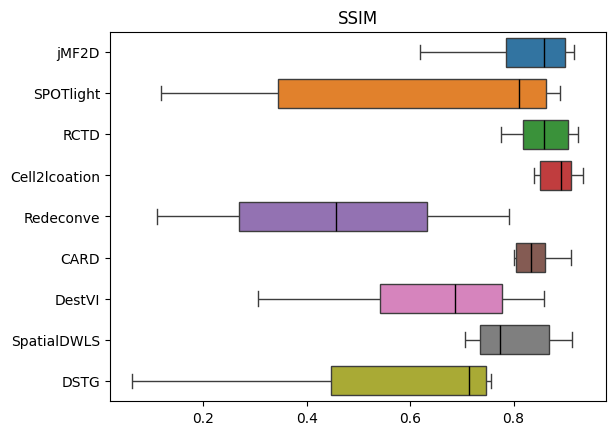

In [10]:
## SSIM
# jMF2D
my_ssim = ssim(ground_truth, jMF2D)
# SPOTlight
spotlight_ssim = ssim(ground_truth, spotlight_res)
# RCTD
RCTD_ssim = ssim(ground_truth, RCTD_res)
# Cell2lcoation
cell2location_ssim= ssim(ground_truth, cell2location_res)
# Redeconve
Redeconve_ssim = ssim(ground_truth, Redeconve_res)
# CARD
CARD_ssim = ssim(ground_truth, CARD_res)
# DestVI
DestVI_ssim = ssim(ground_truth, DestVI_res)
# SpatialDWLS
SpatialDWLS_ssim = ssim(ground_truth, SpatialDWLS_res)
# DSTG
DSTG_ssim = ssim(ground_truth, DSTG_res)
# show
ssim_data = pd.DataFrame({'jMF2D':my_ssim.values[0], 'SPOTlight':spotlight_ssim.values[0],
                         'RCTD':RCTD_ssim.values[0], 'Cell2lcoation':cell2location_ssim.values[0],
                          'Redeconve':Redeconve_ssim.values[0],
                          "CARD":CARD_ssim.values[0],
                          "DestVI":DestVI_ssim.values[0], "SpatialDWLS":SpatialDWLS_ssim.values[0],
                          "DSTG":DSTG_ssim.values[0]})
sns.boxplot(data=ssim_data, orient='h', width=0.7, showfliers= False,medianprops=dict(color="black"))
plt.title("SSIM")

In [11]:
print("the median: jMF2D Cell2location RCTD SPOTlight Redeconvce CARD DestVI SpatialDWLS DSTG")
print("PCC: ",np.median(my_pcc),np.median(cell2location_pcc),
      np.median(RCTD_pcc),np.median(spotlight_pcc),
      np.median(Redeconve_pcc),np.median(CARD_pcc),
      np.median(DestVI_pcc),np.median(SpatialDWLS_pcc),
      np.median(DSTG_pcc))
print("SSIM: ",np.median(my_ssim),np.median(cell2location_ssim),
      np.median(RCTD_ssim),np.median(spotlight_ssim),
      np.median(Redeconve_ssim),np.median(CARD_ssim),
      np.median(DestVI_ssim),np.median(SpatialDWLS_ssim),
      np.median(DSTG_ssim))
print("JS: ",np.median(my_JS),np.median(cell2location_JS),
      np.median(RCTD_JS),np.median(spotlight_JS),
      np.median(Redeconve_JS),np.median(CARD_JS),
      np.median(DestVI_JS),np.median(SpatialDWLS_JS),
      np.median(DSTG_JS))
print("rmse: ",np.median(my_rmse),np.median(cell2location_rmse),
      np.median(RCTD_rmse),np.median(spotlight_rmse),
      np.median(Redeconve_rmse),np.median(CARD_rmse),
      np.median(DestVI_rmse),np.median(SpatialDWLS_rmse),
      np.median(DSTG_rmse))

the median: jMF2D Cell2location RCTD SPOTlight Redeconvce CARD DestVI SpatialDWLS DSTG
PCC:  0.9286889868067614 0.9093934188047996 0.8932008491567675 0.876368157099324 0.5732415272237786 0.8612275376329723 0.8158948964370243 0.8551576040609912 0.7654817243297372
SSIM:  0.8584920132550269 0.8919988776652592 0.8592004927204098 0.8104600896879559 0.4564558674016229 0.833947785148947 0.685941776269041 0.7744736939968189 0.7130446984526477
JS:  0.03735235142300587 0.035517977050860496 0.043775837095797174 0.10750347327535725 0.2957036419492071 0.07223303939165795 0.07763848745896951 0.04997045957867927 0.12937289128008872
rmse:  0.3772343933937027 0.42551784025114614 0.4620833860600069 0.4965270336345929 0.9180401849469644 0.5267723005372678 0.6065223586418631 0.5381748266403134 0.6847431104687772


Fro:  [7.183142540293968, 11.944360293481415, 8.077754612530496, 6.773443680952271, 23.20035506986066, 23.20035506986066, 7.962292804977224, 12.008235010816621, 10.634998525646456, 10.855399225736749]
   jMF2D  SPOTlight  RCTD  Cell2location  Redeconve  CARD  DestVI  \
0   7.18      11.94  8.08           6.77       23.2  7.96   12.01   

   SpatialDWLS   DSTG  
0        10.63  10.86  


C:\Users\12604\AppData\Local\Temp\ipykernel_53704\2518716142.py:23: UserWarning: The palette list has more values (12) than needed (9), which may not be intended.
  ax = sns.barplot(data=data,palette=sns.color_palette("Paired"))
C:\Users\12604\AppData\Local\Temp\ipykernel_53704\2518716142.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=labels,rotation=45)


(array([ 0.,  5., 10., 15., 20., 25.]),
 [Text(0, 0.0, '0'),
  Text(0, 5.0, '5'),
  Text(0, 10.0, '10'),
  Text(0, 15.0, '15'),
  Text(0, 20.0, '20'),
  Text(0, 25.0, '25')])

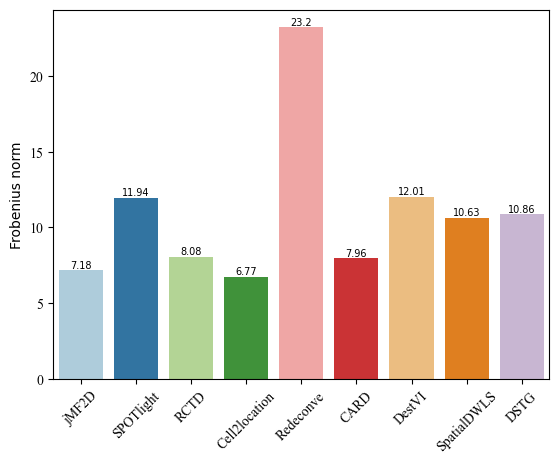

In [14]:
## F-norm
from scipy.interpolate import make_interp_spline
jMF2D_f = np.linalg.norm(jMF2D - ground_truth, 'fro')
spotlight_f = np.linalg.norm(spotlight_res - ground_truth, 'fro')
RCTD_f = np.linalg.norm(RCTD_res - ground_truth, 'fro')
cell2location_f = np.linalg.norm(cell2location_res - ground_truth, 'fro')
Redeconve_f= np.linalg.norm(Redeconve_res - ground_truth, 'fro')
CARD_f = np.linalg.norm(CARD_res - ground_truth, 'fro')
DestVI_f = np.linalg.norm(DestVI_res - ground_truth, 'fro')
SpatialDWLS_f = np.linalg.norm(SpatialDWLS_res - ground_truth, 'fro')
DSTG_f = np.linalg.norm(DSTG_res - ground_truth, 'fro')

print("Fro: ",[jMF2D_f,spotlight_f,RCTD_f,cell2location_f,Redeconve_f,
                   Redeconve_f,CARD_f,DestVI_f,SpatialDWLS_f,DSTG_f])

t = [jMF2D_f,spotlight_f,RCTD_f,cell2location_f,Redeconve_f,CARD_f,DestVI_f,SpatialDWLS_f,DSTG_f]

t = [float('{:.2f}'.format(i)) for i in t]
data = pd.DataFrame({"jMF2D":[t[0]],"SPOTlight":[t[1]],"RCTD":[t[2]],"Cell2location":[t[3]],"Redeconve":[t[4]],
                     "CARD":[t[5]],"DestVI":[t[6]],"SpatialDWLS":[t[7]],"DSTG":[t[8]]})
print(data)
labels = ["jMF2D","SPOTlight","RCTD","Cell2location","Redeconve","CARD","DestVI","SpatialDWLS","DSTG"]
ax = sns.barplot(data=data,palette=sns.color_palette("Paired"))
ax.set_xticklabels(labels=labels,rotation=45)
plt.ylabel("Frobenius norm")
x = [0,1,2,3,4,5,6,7,8]
y = t
model = make_interp_spline(x, y)
xs = np.linspace(0, 8, 500)
ys = model(xs)
for a, b in zip(x, y):
    ax.text(a, b, b, ha='center', va='bottom', fontsize=7)
plt.xticks(fontproperties='Times New Roman', size=10)
plt.yticks(fontproperties='Times New Roman', size=10)